
# Clasificación con **Árbol de Decisión** vs **SVM** — *Dataset `penguins`*

**Objetivo didáctico (simple y guiado):**
1. **EDA** breve del dataset `penguins`.
2. **Ejercicio 1 — Árbol de Decisión (binario):** *Adelie vs No‑Adelie* usando dos medidas corporales.
   - Comparar **accuracy** en función de `max_depth`.
   - Elegir el **mejor depth** según TEST.
   - Ver **regiones de decisión** (TRAIN/TEST).
   - Dibujar el **árbol** con `plot_tree`.
   - Calcular **matriz de confusión** (vista didáctica TP/FP/FN/TN) y métricas.
3. **Ejercicio 2 — SVM (multiclase):** predecir **species** con dos medidas.
   - Tres tomas separadas (lineal, RBF, polinómico) para que el alumno **experimente** con `C`, `gamma`, `degree`.
   - Matrices de confusión + `classification_report` y **regiones de decisión**.
4. **Preguntas finales**.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC

from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams['figure.figsize'] = (7.2, 4.8)
plt.rcParams['axes.grid'] = True



## 1) Carga de datos y **EDA** breve


Shape: (333, 7)


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island,sex
0,Adelie,39.1,18.7,181.0,3750.0,Torgersen,Male
1,Adelie,39.5,17.4,186.0,3800.0,Torgersen,Female
2,Adelie,40.3,18.0,195.0,3250.0,Torgersen,Female
3,Adelie,36.7,19.3,193.0,3450.0,Torgersen,Female
4,Adelie,39.3,20.6,190.0,3650.0,Torgersen,Male


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057
std,5.468668,1.969235,14.015765,805.215802
min,32.100000,13.100000,172.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.600000,18.700000,213.000000,4775.000000
max,59.600000,21.500000,231.000000,6300.000000


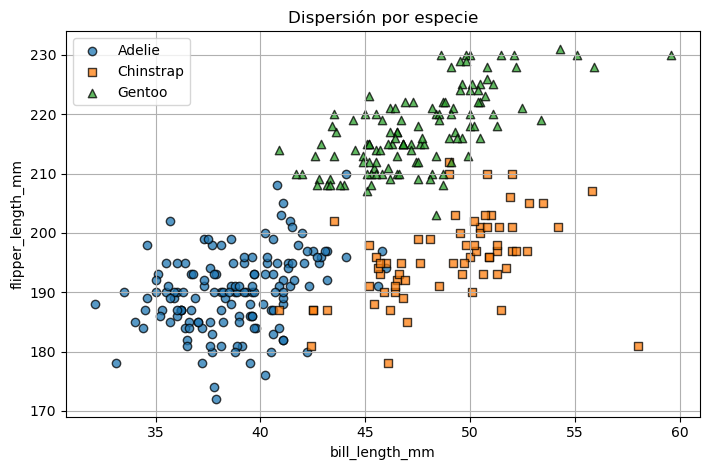

In [3]:

penguins = sns.load_dataset('penguins')
cols = ['species','bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g','island','sex']
df = penguins[cols].dropna().reset_index(drop=True)

print("Shape:", df.shape)
display(df.head())

display(df[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']].describe())

plt.figure()
for sp, mk in zip(df['species'].unique(), ['o','s','^']):
    m = (df['species']==sp)
    plt.scatter(df.loc[m,'bill_length_mm'], df.loc[m,'flipper_length_mm'],
                alpha=0.75, edgecolor='k', marker=mk, label=sp)
plt.xlabel('bill_length_mm'); plt.ylabel('flipper_length_mm')
plt.title('Dispersión por especie')
plt.legend(); plt.tight_layout(); plt.show()



## 2) **Ejercicio 1 — Árbol de Decisión (binario)**
**Target:** `Adelie` (=1) vs `No‑Adelie` (=0)  
**Features:** elige **2** medidas corporales.


In [4]:

FEAT_X = 'bill_length_mm'
FEAT_Y = 'flipper_length_mm'

X = df[[FEAT_X, FEAT_Y]].values
y = (df['species'] == 'Adelie').astype(int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
print("Shapes — X_train/X_test:", X_train.shape, X_test.shape)


Shapes — X_train/X_test: (233, 2) (100, 2)


### 2.1 Precisión según **max_depth**

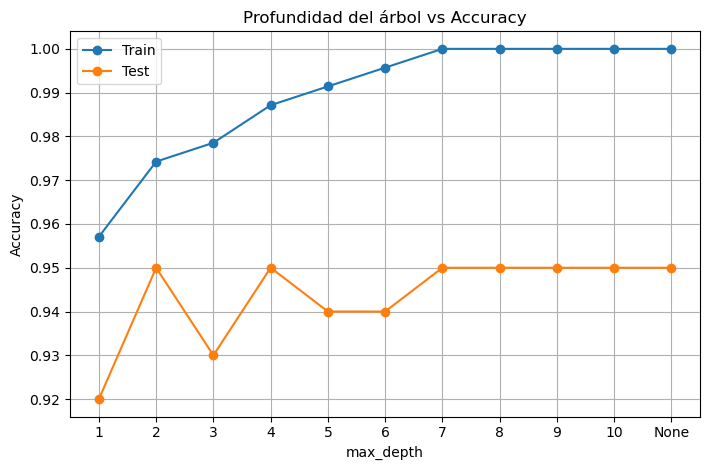

Mejor max_depth según test: 2 → Accuracy: 0.95


In [5]:

depths = [1,2,3,4,5,6,7,8,9,10,None]
train_scores, test_scores = [], []

for d in depths:
    clf = DecisionTreeClassifier(random_state=42, max_depth=d)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

x_labels = [str(d) if d is not None else 'None' for d in depths]

plt.figure()
plt.plot(range(len(depths)), train_scores, marker='o', label='Train')
plt.plot(range(len(depths)), test_scores, marker='o', label='Test')
plt.xticks(range(len(depths)), x_labels)
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Profundidad del árbol vs Accuracy'); plt.legend(); plt.tight_layout(); plt.show()

best_idx = int(np.argmax(test_scores))
print("Mejor max_depth según test:", depths[best_idx], "→ Accuracy:", round(test_scores[best_idx],3))
best_depth = depths[best_idx]
best_tree = DecisionTreeClassifier(random_state=42, max_depth=best_depth).fit(X_train, y_train)


### 2.2 **Regiones de decisión**

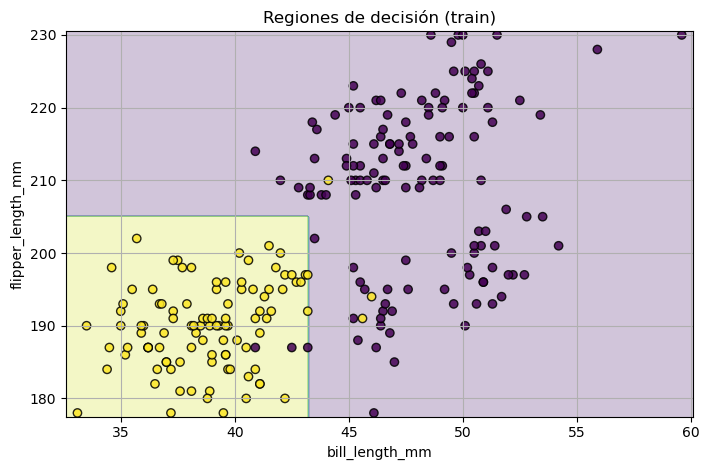

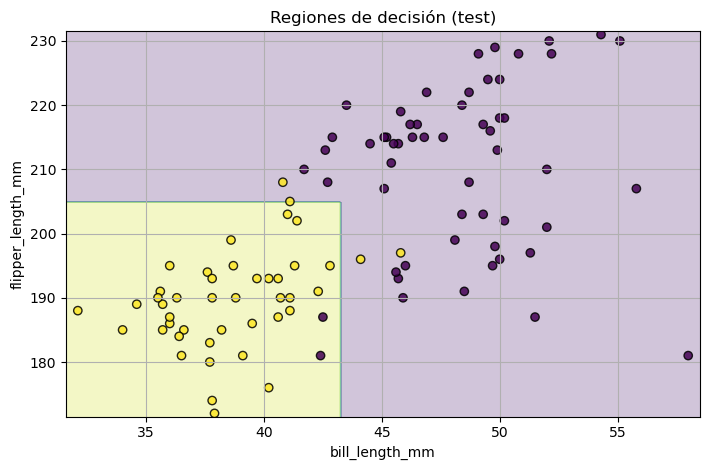

In [6]:

def plot_decision_regions_2d(model, X, y, title='Decision regions'):
    x_min, x_max = X[:, 0].min()-0.5, X[:, 0].max()+0.5
    y_min, y_max = X[:, 1].min()-0.5, X[:, 1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y, edgecolor='k', alpha=0.85)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y); plt.title(title)
    plt.tight_layout(); plt.show()

plot_decision_regions_2d(best_tree, X_train, y_train, title='Regiones de decisión (train)')
plot_decision_regions_2d(best_tree, X_test,  y_test,  title='Regiones de decisión (test)')


### 2.3 **Árbol** con `plot_tree`

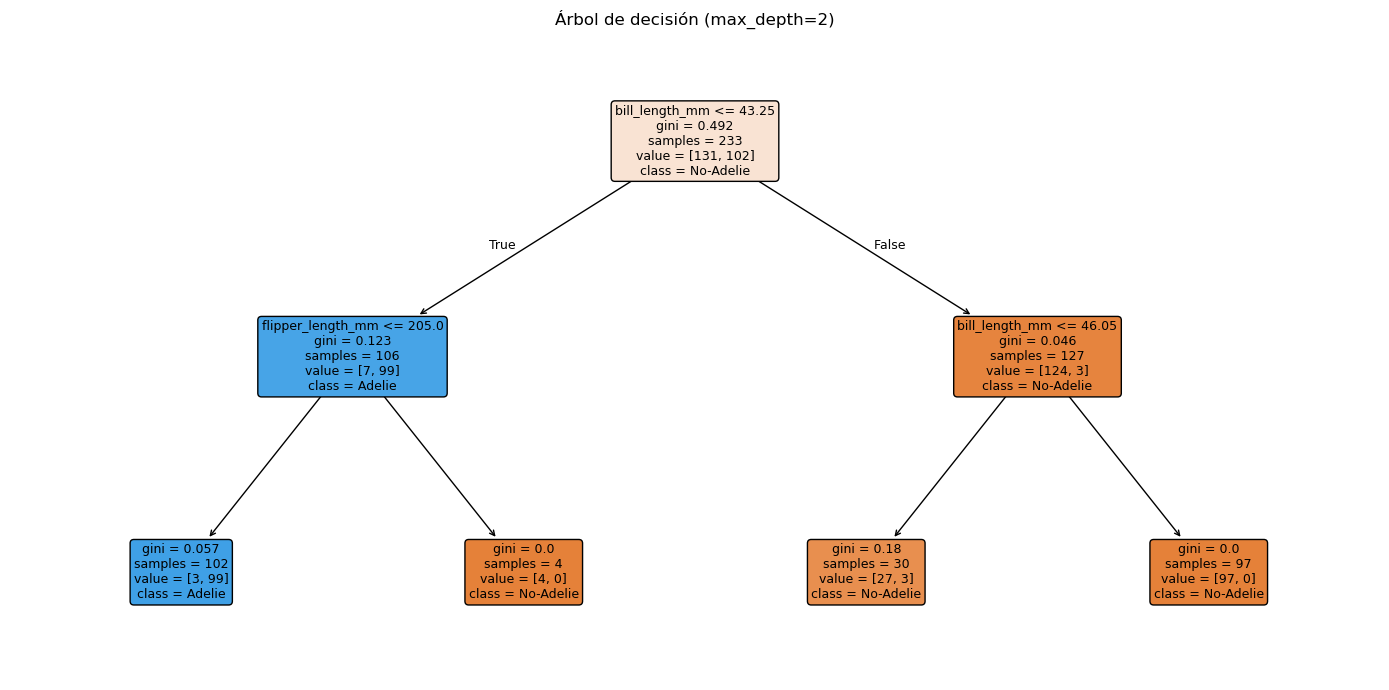

In [7]:

plt.figure(figsize=(14,7))
plot_tree(best_tree,
          feature_names=[FEAT_X, FEAT_Y],
          class_names=['No-Adelie','Adelie'],
          filled=True, rounded=True, fontsize=9)
plt.title(f'Árbol de decisión (max_depth={best_depth})')
plt.tight_layout(); plt.show()


### 2.4 **Matriz de Confusión** (vista didáctica) + métricas

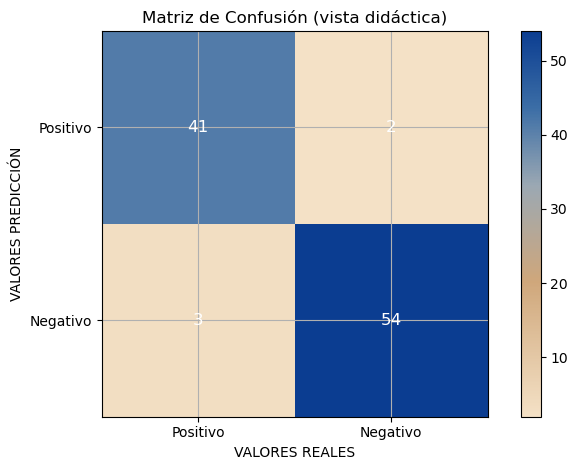

TP, TN, FP, FN = 41 54 2 3
Accuracy : 0.950
Precision: 0.953
Recall   : 0.932
F1-score : 0.943

Informe de clasificación (TEST):

              precision    recall  f1-score   support

   No-Adelie       0.95      0.96      0.96        56
      Adelie       0.95      0.93      0.94        44

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



In [8]:

y_pred_best = best_tree.predict(X_test)
cm_official = confusion_matrix(y_test, y_pred_best, labels=[1,0])
TP, FN, FP, TN = cm_official.ravel()

cm_view = np.array([[TP, FP],
                    [FN, TN]])

brown_to_blue = LinearSegmentedColormap.from_list(
    "brown_to_blue",
    [
        (0.00, "#F4E1C6"),
        (0.35, "#CFA77B"),
        (0.60, "#9BA8B3"),
        (0.80, "#3C6EA6"),
        (1.00, "#0B3D91"),
    ],
    N=256
)

fig, ax = plt.subplots()
im = ax.imshow(cm_view, cmap=brown_to_blue)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Positivo','Negativo'])
ax.set_yticklabels(['Positivo','Negativo'])
ax.set_xlabel('VALORES REALES'); ax.set_ylabel('VALORES PREDICCIÓN')
plt.colorbar(im, ax=ax)

for i in range(2):
    for j in range(2):
        ax.text(j, i, int(cm_view[i, j]), ha='center', va='center', color='white', fontsize=12)

plt.title('Matriz de Confusión (vista didáctica)')
plt.tight_layout(); plt.show()

acc  = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best, zero_division=0)
rec  = recall_score(y_test, y_pred_best, zero_division=0)
f1   = f1_score(y_test, y_pred_best, zero_division=0)

print(f"TP, TN, FP, FN = {TP} {TN} {FP} {FN}")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print('\nInforme de clasificación (TEST):\n')
print(classification_report(y_test, y_pred_best, digits=2, target_names=['No-Adelie','Adelie']))



## 3) **Ejercicio 2 — SVM (multiclase)**
Target: `species` (Adelie / Chinstrap / Gentoo).  
Usamos las mismas features para comparar.


In [9]:

Xs = df[[FEAT_X, FEAT_Y]].values
ys = (df['species'] == 'Adelie').astype(int).values

Xs_tr, Xs_te, ys_tr, ys_te = train_test_split(
    Xs, ys, test_size=0.30, random_state=42, stratify=ys
)

def plot_cm(cm, classes, title):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks(np.arange(len(classes))); ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes); ax.set_yticklabels(classes)
    ax.set_xlabel('Predicción'); ax.set_ylabel('Real')
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, int(cm[i, j]), ha='center', va='center', color='black')
    plt.colorbar(im, ax=ax)
    plt.title(title); plt.tight_layout(); plt.show()

def plot_regions_multiclass(model, X, y, title):
    x_min, x_max = X[:,0].min()-1.0, X[:,0].max()+1.0
    y_min, y_max = X[:,1].min()-1.0, X[:,1].max()+1.0
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z_lab = model.predict(grid).reshape(xx.shape)
    classes = model.classes_
    mapping = {cls:i for i,cls in enumerate(classes)}
    Z = np.vectorize(mapping.get)(Z_lab)
    y_num = np.vectorize(mapping.get)(y)
    cmap = ListedColormap(['#1f77b4', '#d62728', '#2ca02c'])
    plt.figure(figsize=(6.5,5))
    plt.contourf(xx, yy, Z, levels=np.arange(len(classes)+1)-0.5, cmap=cmap, alpha=0.25)
    plt.scatter(X[:,0], X[:,1], c=y_num, cmap=cmap, edgecolor='k', alpha=0.9)
    plt.xlabel(FEAT_X); plt.ylabel(FEAT_Y)
    plt.title(title + f"  (clases: {classes.tolist()})")
    plt.tight_layout(); plt.show()


### 3.1 **SVM lineal** (punto de partida)

=== SVM lineal ===
Parámetros: kernel='linear', C=1.0
Accuracy (train/test): 0.97 / 0.96


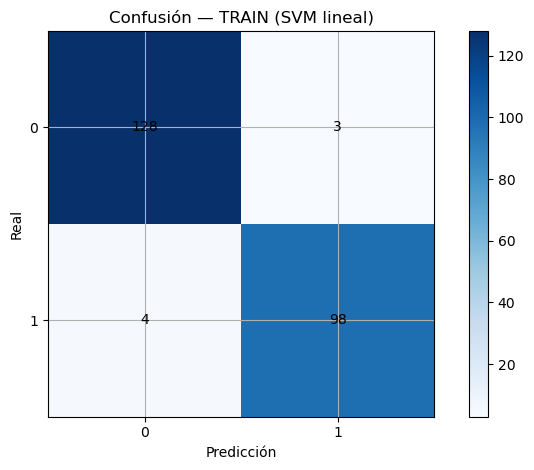

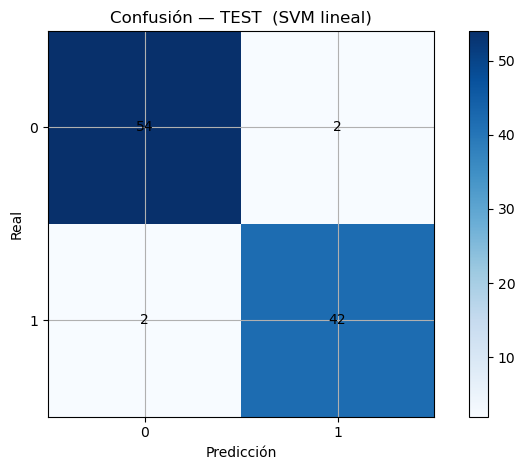

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.964     0.964     0.964        56
           1      0.955     0.955     0.955        44

    accuracy                          0.960       100
   macro avg      0.959     0.959     0.959       100
weighted avg      0.960     0.960     0.960       100



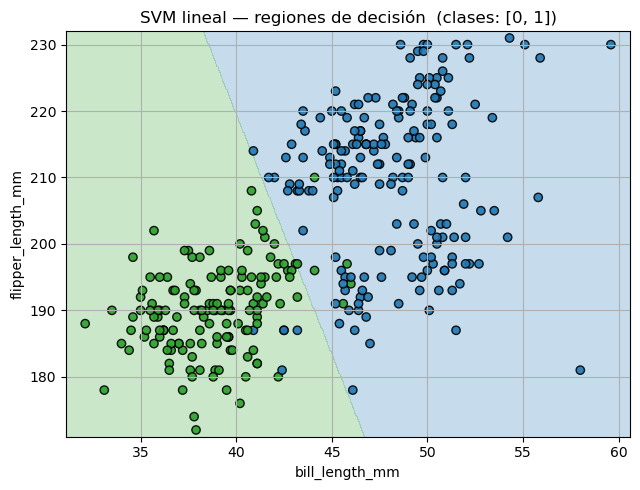

In [10]:

svm_lin = Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(kernel='linear', C=1.0, random_state=42))])
svm_lin.fit(Xs_tr, ys_tr)

pred_tr = svm_lin.predict(Xs_tr)
pred_te = svm_lin.predict(Xs_te)

print("=== SVM lineal ===")
print("Parámetros: kernel='linear', C=1.0")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_lin.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_lin.classes_)
plot_cm(cm_tr, svm_lin.classes_, "Confusión — TRAIN (SVM lineal)")
plot_cm(cm_te, svm_lin.classes_, "Confusión — TEST  (SVM lineal)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_lin, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM lineal — regiones de decisión")


### 3.2 **SVM RBF** (curvatura con `gamma`)


=== SVM RBF ===
Parámetros: kernel='rbf', gamma='scale', C=1.0
Accuracy (train/test): 0.974 / 0.96


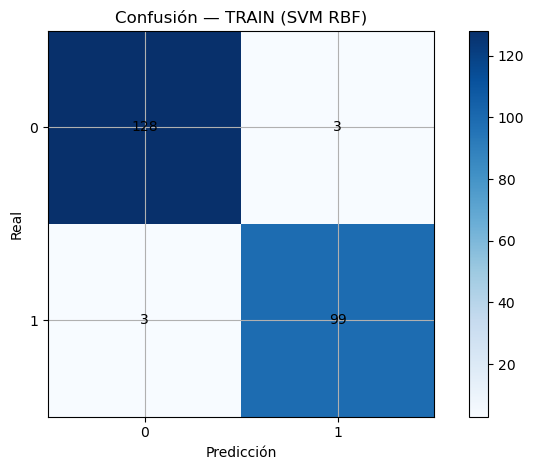

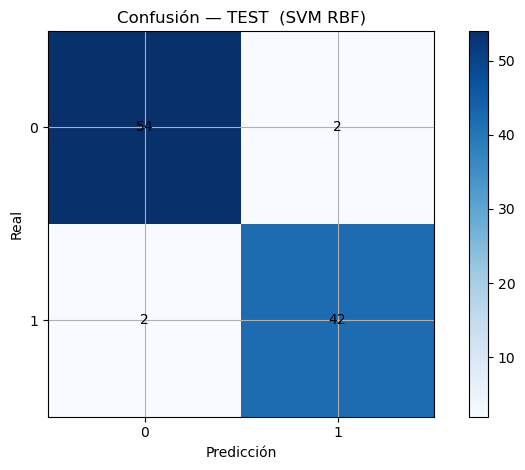

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.964     0.964     0.964        56
           1      0.955     0.955     0.955        44

    accuracy                          0.960       100
   macro avg      0.959     0.959     0.959       100
weighted avg      0.960     0.960     0.960       100



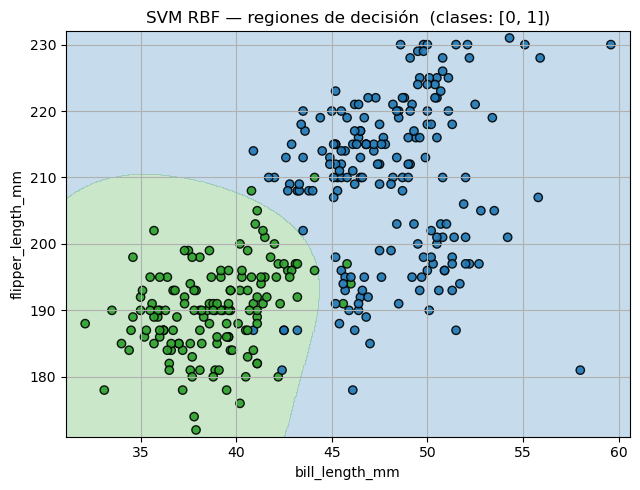

In [11]:

svm_rbf = Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42))])
svm_rbf.fit(Xs_tr, ys_tr)

pred_tr = svm_rbf.predict(Xs_tr)
pred_te = svm_rbf.predict(Xs_te)

print("\n=== SVM RBF ===")
print("Parámetros: kernel='rbf', gamma='scale', C=1.0")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_rbf.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_rbf.classes_)
plot_cm(cm_tr, svm_rbf.classes_, "Confusión — TRAIN (SVM RBF)")
plot_cm(cm_te, svm_rbf.classes_, "Confusión — TEST  (SVM RBF)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_rbf, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM RBF — regiones de decisión")


### 3.3 **SVM polinómico** (control con `degree`)


=== SVM polinómico ===
Parámetros: kernel='poly', degree=3, gamma='scale', C=1.0
Accuracy (train/test): 0.897 / 0.9


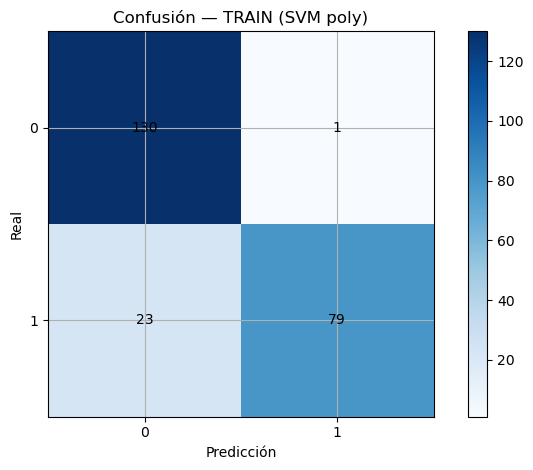

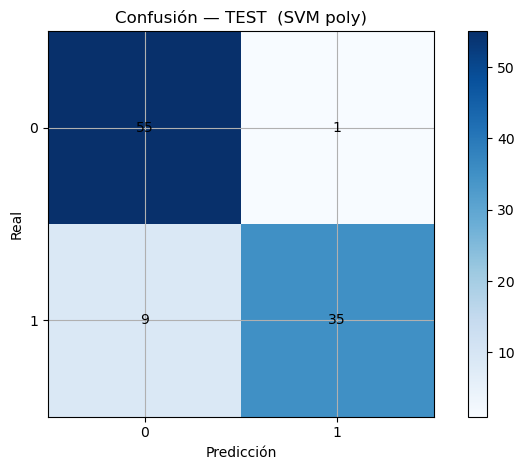

Classification report (TEST):
               precision    recall  f1-score   support

           0      0.859     0.982     0.917        56
           1      0.972     0.795     0.875        44

    accuracy                          0.900       100
   macro avg      0.916     0.889     0.896       100
weighted avg      0.909     0.900     0.898       100



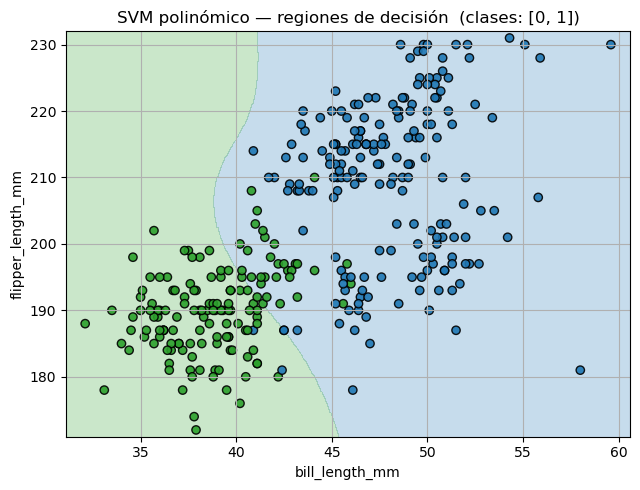

In [12]:

svm_poly = Pipeline([('scaler', StandardScaler()),
                     ('svc', SVC(kernel='poly', degree=3, gamma='scale', C=1.0, random_state=42))])
svm_poly.fit(Xs_tr, ys_tr)

pred_tr = svm_poly.predict(Xs_tr)
pred_te = svm_poly.predict(Xs_te)

print("\n=== SVM polinómico ===")
print("Parámetros: kernel='poly', degree=3, gamma='scale', C=1.0")
print("Accuracy (train/test):", round(accuracy_score(ys_tr, pred_tr),3), "/", round(accuracy_score(ys_te, pred_te),3))

cm_tr = confusion_matrix(ys_tr, pred_tr, labels=svm_poly.classes_)
cm_te = confusion_matrix(ys_te, pred_te, labels=svm_poly.classes_)
plot_cm(cm_tr, svm_poly.classes_, "Confusión — TRAIN (SVM poly)")
plot_cm(cm_te, svm_poly.classes_, "Confusión — TEST  (SVM poly)")

print("Classification report (TEST):\n", classification_report(ys_te, pred_te, digits=3))
plot_regions_multiclass(svm_poly, np.r_[Xs_tr, Xs_te], np.r_[ys_tr, ys_te],
                        "SVM polinómico — regiones de decisión")



## 4) Preguntas para entregar

1. ¿Qué `max_depth` ofrece mejor **accuracy de TEST** en el árbol? ¿Por qué no conviene usar `None` por defecto?
2. Mira la frontera del árbol en TEST. ¿Dónde ves **sobreajuste**? Cita ejemplos de “serruchos” o regiones minúsculas.
3. Compara las **matrices de confusión** del árbol y del SVM lineal: ¿cuál equilibra mejor aciertos en cada clase?
4. En SVM **RBF**, modifica `gamma` y `C` (0.1, 1, 10): ¿cómo cambia la frontera y el accuracy de TEST? Explica el rol de cada hiperparámetro.
5. En SVM **polinómico**, prueba `degree=2` y `degree=4`. ¿Mejora el test? ¿Qué efecto visual observas al aumentar el grado?
